## Fraud Detection
Make Money with Machine Learning week 3 homework  
using Kaggle dataset from [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data)  
An initial approach to creating a baseline model

### Import required modules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Load the training data

In [0]:
train_transaction = pd.read_csv('data/train_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')

In [5]:
train_transaction.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_identity.head(3)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [7]:
print(f'Shape of train_transaction: {train_transaction.shape}')
print(f'Shape of train_identity: {train_identity.shape}')

Shape of train_transaction: (590540, 394)
Shape of train_identity: (144233, 41)


The data were broken into Transaction and Identity tables which are joined by TransactionID  

The following features are categorical:

Transaction data
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

Identity data

- DeviceType
- DeviceInfo
- id_12 - id_38

For details, check [Data Description and Discussion](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) on Kaggle website.

### How to merge the Transaction and Identity tables?

Transaction table has more TransactionID than Identity table. Union merge will introduce a lot of missing values in the merged data. On the other hand, intersectin merge will drop data of a lot of TransactionID.

#### Union merge?

In [8]:
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='outer')
print(f'Shape of union merge: {df.shape}')
print(f'% of fraud transactions = {df.isFraud.value_counts(normalize=True)[1]}')

Shape of union merge: (590540, 434)
% of fraud transactions = 0.03499000914417313


#### Intersection merge?

In [9]:
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='inner')
print(f'Shape of intersection merge: {df.shape}')
print(f'% of fraud transactions = {df.isFraud.value_counts(normalize=True)[1]}')

Shape of intersection merge: (144233, 434)
% of fraud transactions = 0.07847025299342036


#### Go ahead with intersection merge
Although intersection merge resulted in less TransactionID, the % of fraud transactions is higher than that of union merge. As an initial baseline attempt, we shall use intersection merge to reduce the need for handling too many missing values.

### Create features matrix X and target vector y

In [0]:
# Exclude target and indexing columns from input features
X = df.drop(columns=['isFraud', 'TransactionDT', 'TransactionID'])
y = df['isFraud']
del df # to save some memory

### Drop features with more than 90% of one single value or just missing value
With such high % of a constant value, the feature might not have much effect on the transaction. A simple initial approach again.

In [11]:
cols_to_drop = [col for col in X if X[col].value_counts(dropna=False, normalize=True).iloc[0]>0.9]
X = X.drop(columns=cols_to_drop)
print(f'Columns dropped: {cols_to_drop}')
print(f'Number of columns dropped: {len(cols_to_drop)}')

Columns dropped: ['dist1', 'C3', 'C5', 'C9', 'D11', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V169', 'V173', 'V186', 'V187', 'V191', 'V192', 'V193', 'V196', 'V206', 'V220', 'V238', 'V240', 'V241', 'V281', 'V284', 'V286', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V304', 'V305', 'V309', 'V311', 'V319', 'V320', 'V321', 'id_07', 'id_08', 'id_11', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_36']
Number of columns dropped: 102


### Create lists of categorical features and numerical features
#### Categorical features (as given by data provider)
ProductCD, 
card1 - card6, 
addr1, addr2, 
P_emaildomain, R_emaildomain, 
M1 - M9

DeviceType, 
DeviceInfo, 
id_12 - id_38

In [0]:
cat_cols = (['ProductCD'] 
            + [f'card{i}' for i in range(1, 7)]
            + ['addr1', 'addr2']
            + ['P_emaildomain', 'R_emaildomain']
            + [f'M{i}' for i in range(1, 10)]
            + ['DeviceType', 'DeviceInfo']
            + [f'id_{i}' for i in range(12, 39)])
# Keep only columns still in X
cat_cols = [col for col in cat_cols if col in X]
# Create list of numerical columns
num_cols = [col for col in X if col not in cat_cols]

### Explore the categorical features

In [13]:
X[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Data columns (total 33 columns):
ProductCD        144233 non-null object
card1            144233 non-null int64
card2            143331 non-null float64
card3            144061 non-null float64
card4            144049 non-null object
card5            143277 non-null float64
card6            144055 non-null object
addr1            83786 non-null float64
addr2            83786 non-null float64
P_emaildomain    130842 non-null object
R_emaildomain    131083 non-null object
M4               60831 non-null object
DeviceType       140810 non-null object
DeviceInfo       118666 non-null object
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20

- 13 features contain numeric values (dtypes float64(12), int64(1)
- 20 features contain object values (i.e. string values in this case).

#### Work with the 'object' dtype columns first

In [0]:
obj_cols = [col for col in cat_cols if X[col].dtype=='object']

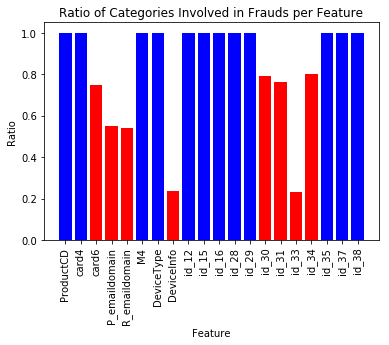

In [16]:
X[obj_cols] = X[obj_cols].fillna('unknown')
all_cats = X[obj_cols].apply(lambda x: x.nunique())
fraud_cats = X.loc[y==1][obj_cols].apply(lambda x: x.nunique())
fraud_ratios = fraud_cats / all_cats
plt.bar(fraud_ratios.index, fraud_ratios, 
        color=['red' if ratio < 1 else 'blue' for ratio in fraud_ratios])
plt.xticks(rotation='vertical')
plt.ylabel('Ratio')
plt.xlabel('Feature',)
plt.title('Ratio of Categories Involved in Frauds per Feature')
plt.show()

Red bars are features with categories not involved in frauds. They might be an opportunity for reducing number of categories.    
Let us see if it is possible.

In [18]:
for col in obj_cols:
    set_all_cats = set(X[col].value_counts().index)
    set_fraud_cats = set(X.loc[y==1][col].value_counts().index) 
    print(f'{col}, Categories not involved in frauds = {len(set_all_cats) - len(set_fraud_cats)}')
    if len(set_all_cats) - len(set_fraud_cats) > 0:
        print(set_all_cats - set_fraud_cats)
    print()

ProductCD, Categories not involved in frauds = 0

card4, Categories not involved in frauds = 0

card6, Categories not involved in frauds = 1
{'charge card'}

P_emaildomain, Categories not involved in frauds = 27
{'sc.rr.com', 'frontiernet.net', 'yahoo.de', 'ptd.net', 'twc.com', 'cableone.net', 'juno.com', 'q.com', 'centurylink.net', 'rocketmail.com', 'web.de', 'cfl.rr.com', 'live.fr', 'frontier.com', 'gmail', 'yahoo.co.jp', 'hotmail.fr', 'servicios-ta.com', 'embarqmail.com', 'hotmail.co.uk', 'gmx.de', 'hotmail.de', 'netzero.com', 'att.net', 'roadrunner.com', 'windstream.net', 'yahoo.co.uk'}

R_emaildomain, Categories not involved in frauds = 28
{'sc.rr.com', 'frontiernet.net', 'yahoo.de', 'ptd.net', 'twc.com', 'cableone.net', 'juno.com', 'scranton.edu', 'q.com', 'centurylink.net', 'web.de', 'cfl.rr.com', 'live.fr', 'frontier.com', 'gmail', 'yahoo.co.jp', 'hotmail.fr', 'servicios-ta.com', 'verizon.net', 'embarqmail.com', 'hotmail.co.uk', 'gmx.de', 'hotmail.de', 'netzero.com', 'att.net',

So except card6 and id_34, other features might benefit from having categories reduction.

#### Replace categories not involved in frauds with a single category name: 'others'

In [0]:
to_replace = dict()
for col in obj_cols:
    set_all_cats = set(X[col].value_counts().index)
    set_fraud_cats = set(X.loc[y==1][col].value_counts().index) 
    if len(set_all_cats) - len(set_fraud_cats) > 5:
        to_replace[col] = list(set_all_cats - set_fraud_cats)

X[obj_cols] = X[obj_cols].replace(to_replace, 'others')

In [20]:
X[obj_cols].apply(lambda x: x.nunique())

ProductCD          4
card4              5
card6              4
P_emaildomain     34
R_emaildomain     34
M4                 4
DeviceType         3
DeviceInfo       422
id_12              2
id_15              4
id_16              3
id_28              3
id_29              3
id_30             61
id_31            101
id_33             61
id_34              5
id_35              3
id_37              3
id_38              3
dtype: int64

#### Try to reduce DeviceInfo categories
Trey grouping devices into brand names


In [0]:
X['DeviceInfo'].value_counts()

In [0]:
def rename_device(d):
    
    d = d.lower()
      
    
    for ss in ['unknown', 'others']:
        if d.startswith(ss):
            return ss
    for ss in ['win']:
        if d.startswith(ss):
            return 'windows'
    for ss in ['ios', 'iphone']:
        if d.startswith(ss):
            return 'ios'
    for ss in ['mac']:
        if d.startswith(ss):
            return 'mac os'
    for ss in ['others']:
        if d.startswith(ss):
            return 'others'
    for ss in ['tri']:
        if d.startswith(ss):
            return 'trident'
    for ss in ['rv:']:
        if d.startswith(ss):
            return 'mozilla'
    for ss in ['sm', 'sams', 'gt']:
        if d.startswith(ss):
            return 'samsung'
    for ss in ['ale', 'hi', 'sla', 'cam', 'pra', 'trt', 'hua', 'was', 'mya', 'rne', 'cro', 'bll', 'chc']:
        if d.startswith(ss):
            return 'huawei'
    if 'huaw' in d:
        return 'huawei'
    
    for ss in ['moto', 'xt']:
        if d.startswith(ss):
            return 'motorola'
    for ss in ['z410', 'tab', 'len']:
        if d.startswith(ss):
            return 'lenovo'
    for ss in ['blade', 'zte', 'n95', 'z55', 'z7', 'z8', 'z9']:
        if d.startswith(ss):
            return 'zte'
    for ss in ['lg', 'vs']:
        if d.startswith(ss):
            return 'lg'
    for ss in ['htc']:
        if d.startswith(ss):
            return 'htc'
    for ss in ['mi', 'redmi']:
        if d.startswith(ss):
            return 'mi'
    for ss in ['f3', 'f5']:
        if d.startswith(ss):
            return 'sony'
    for ss in ['50', 'alca']:
        if d.startswith(ss):
            return 'alcatel'
    for ss in ['kf']:
        if d.startswith(ss):
            return 'kindle'
    return 'other_brands'

In [42]:
X['DeviceInfo'] = X['DeviceInfo'].apply(rename_device)
print(f'Number of categories of DeviceInfo was reduced to {X["DeviceInfo"].nunique()}')

Number of categories of DeviceInfo was reduced to 15


#### Try to reduce id_30 categories
Try grouping values into brand names

In [38]:
X['id_30'].value_counts()

unknown             66668
Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
Mac OS X 10_12_6     2559
Mac OS X 10_11_6     2348
iOS 11.3.0           2016
Windows 8.1          1914
Mac OS X 10_10_5     1651
iOS 11.2.6           1647
iOS 10.3.3           1558
Mac OS X 10_13_2     1421
Mac OS X 10_13_1     1211
iOS 11.2.5           1200
Linux                1136
Android              1079
iOS 11.2.2            902
Mac OS X 10_13_3      860
iOS 11.2.0            852
others                773
Mac OS X 10_13_4      759
iOS 11.1.1            700
iOS 11.0.3            659
Android 7.1.1         630
Mac OS X 10_9_5       570
Android 6.0.1         566
iOS 10.3.2            428
iOS 9.3.5             414
                    ...  
Android 8.0.0         343
Mac                   303
Mac OS X 10.13        287
iOS 10.2.1            285
iOS                   274
iOS 11.1.0            271
Windows Vista         246
iOS 10.3.1  

In [0]:
def rename_id_30(d):
    d = d.lower()
    
    if d.startswith('mac'):
        return 'mac os'
    
    for ss in ['unknown', 'others', 'windows', 'ios', 'android', 'linux']:
        if d.startswith(ss):
            return ss
    
    return 'other_brands'

In [48]:
X['id_30'] = X['id_30'].apply(rename_device)
print(f'Number of categories of id_30 was reduced to {X["id_30"].nunique()}')

Number of categories of id_30 was reduced to 6


#### Try to reduce id_31 categories
Try grouping values into brand names

In [50]:
X['id_31'].value_counts()

chrome 63.0                   22000
mobile safari 11.0            13423
mobile safari generic         11474
ie 11.0 for desktop            9030
safari generic                 8195
chrome 62.0                    7182
chrome 65.0                    6871
chrome 64.0                    6711
chrome 63.0 for android        5806
chrome generic                 4778
chrome 66.0                    4264
edge 16.0                      4188
unknown                        3951
chrome 64.0 for android        3473
chrome 65.0 for android        3336
firefox 57.0                   3315
mobile safari 10.0             2779
chrome 66.0 for android        2349
chrome 62.0 for android        2097
edge 15.0                      1600
chrome generic for android     1158
firefox 59.0                   1099
samsung browser 6.2            1061
firefox 58.0                    833
chrome 49.0                     719
firefox                         673
ie 11.0 for tablet              647
chrome 61.0                 

In [0]:
def rename_id_31(d):
    d = d.lower()
    
    if d.startswith('chrome'):
        if 'android' in d:
            return 'chrome for android'
        else:
            return 'chrome'
    
    for ss in ['android', 'firefox']:
        if ss in d:
            return ss
    
    for ss in ['unknown', 'others', 'edge', 'ie', 'samsung', 'opera', 'safari', 'mobile safari', 'google']:
        if d.startswith(ss):
            return ss
    
    return 'other_brands'

In [66]:
X['id_31'] = X['id_31'].apply(rename_device)
print(f'Number of categories of id_31 was reduced to {X["id_31"].nunique()}')

Number of categories of id_31 was reduced to 5


#### Convert id_33 to non-object dtype categorical feature.
id_33 categories are screen resolutions

In [0]:
X['id_33'] = X['id_33'].apply(lambda v: v.split('x')[1 if 'x' in v else 0]).replace(['unknown', 'others'], np.nan).astype(np.float32)

In [0]:
obj_cols.remove('id_33')
non_obj_cols = [col for col in cat_cols if X[col].dtype != 'object'] + ['id_33']

### Use simple encoding for non-object dtype features

In [107]:
X[non_obj_cols] = X[non_obj_cols].fillna('nan')
ord_enc = OrdinalEncoder()
ord_enc.fit(X[non_obj_cols].astype(str))

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

### Split data into train and test sets
Since fraud and non-fraud clsses are imbalanced, we use StatifiedShuffleSplit to make the ratio of frauds in both train and test sets similar.

In [0]:
sss = StratifiedShuffleSplit(n_splits=1)
for train_rows, test_rows in sss.split(X, y):
    X_train, X_test = X.iloc[train_rows], X.iloc[test_rows]
    y_train, y_test = y.iloc[train_rows], y.iloc[test_rows]
del X, y # to save some memory

### Impute missing values in numeric features with the mean of each feature

In [0]:
imp = SimpleImputer(strategy='mean')
imp.fit(X_train[num_cols])
X_train[num_cols] = imp.transform(X_train[num_cols])

### Normalize numeric features

In [0]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])

### One-hot encode the object detype categorical features

In [111]:
oht_enc = OneHotEncoder(handle_unknown='ignore')
oht_enc.fit(X_train[obj_cols].astype(str))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [0]:
arr_num = np.array(X_train[num_cols])
arr_non_obj = np.array(ord_enc.transform(X_train[non_obj_cols].astype(str)))
arr_obj = oht_enc.transform(X_train[obj_cols].astype(str)).toarray()
X_train = np.concatenate((arr_num, arr_non_obj, arr_obj), axis=1)

### Create and fit the Logistic Regression Model 

In [114]:
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Preprocess the test data in the same way as we did the train data

In [0]:
X_test[num_cols] = imp.transform(X_test[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test[non_obj_cols] = X_test[non_obj_cols].fillna('nan')

arr_num = np.array(X_test[num_cols])
arr_non_obj = np.array(ord_enc.transform(X_test[non_obj_cols].astype(str)))
arr_obj = oht_enc.transform(X_test[obj_cols].astype(str)).toarray()
X_test = np.concatenate((arr_num, arr_non_obj, arr_obj), axis=1)

### Evaluate the model with test data

In [127]:
y_pred = model.predict(X_test)
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=['normal', 'fraud']))

Classification Report
              precision    recall  f1-score   support

      normal       0.96      0.99      0.97     13292
       fraud       0.83      0.46      0.60      1132

    accuracy                           0.95     14424
   macro avg       0.89      0.73      0.78     14424
weighted avg       0.95      0.95      0.94     14424



### Conclusion
Using this baseline Logistic Regression model, we can only predict 46% of fraud cases in the test data (recall=0.46) but those we predict as fraud cases have high probability of being fraud (precision=0.83). 